In [1]:
#import library

import tensorflow as tf 
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from math import sqrt
import random as python_random
from datetime import datetime   
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_excel
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

In [2]:
#read data to pandas dataframe
data = pd.read_excel (r'C:\Users\cater\Downloads\datas\usdidr.xlsx', header = 0)
data.columns = ['Date','Open','High','Low','Close']
data['Date'] = pd.to_datetime(data['Date'])
data.head(10)

,Date,Open,High,Low,Close
0,2007-01-01,8993.5,8993.5,8993.5,8994
1,2007-01-02,8983.0,9003.0,8938.0,8990
2,2007-01-03,8980.0,8992.0,8960.0,8965
3,2007-01-04,8985.0,9021.0,8980.0,9000
4,2007-01-05,9000.0,9030.0,8995.0,9015
5,2007-01-08,9013.0,9055.0,9013.0,9040
6,2007-01-09,9037.0,9040.0,9010.0,9035
7,2007-01-10,9047.5,9092.5,9047.5,9074
8,2007-01-11,9027.5,9141.5,9027.5,9120
9,2007-01-12,9130.0,9186.0,9120.0,9122


In [3]:
#data.set_index('Date', inplace= True)

In [4]:
#get the required data
data = data.loc[(data['Date']<='2022.09.30') & (data['Date']>='2007.01.01')]

#drop unnecessary data
data.drop(data.loc[data['Date']=='2022.09.30'].index, inplace=True)

In [5]:
#data.columns =['Open','High','Low','Close']

In [6]:
data.describe()

,Open,High,Low,Close
count,4064.000000,4064.000000,4064.000000,4064.000000
mean,11835.486713,11868.827436,11815.133981,11837.623524
std,2242.648692,2248.551704,2241.239465,2245.819002
min,8462.500000,8472.500000,8457.500000,8460.000000
25%,9365.000000,9402.375000,9341.875000,9375.000000
50%,12187.500000,12217.500000,12167.000000,12187.500000
75%,14007.500000,14045.000000,13988.875000,14010.000000
max,16505.000000,16640.000000,16475.000000,16575.000000


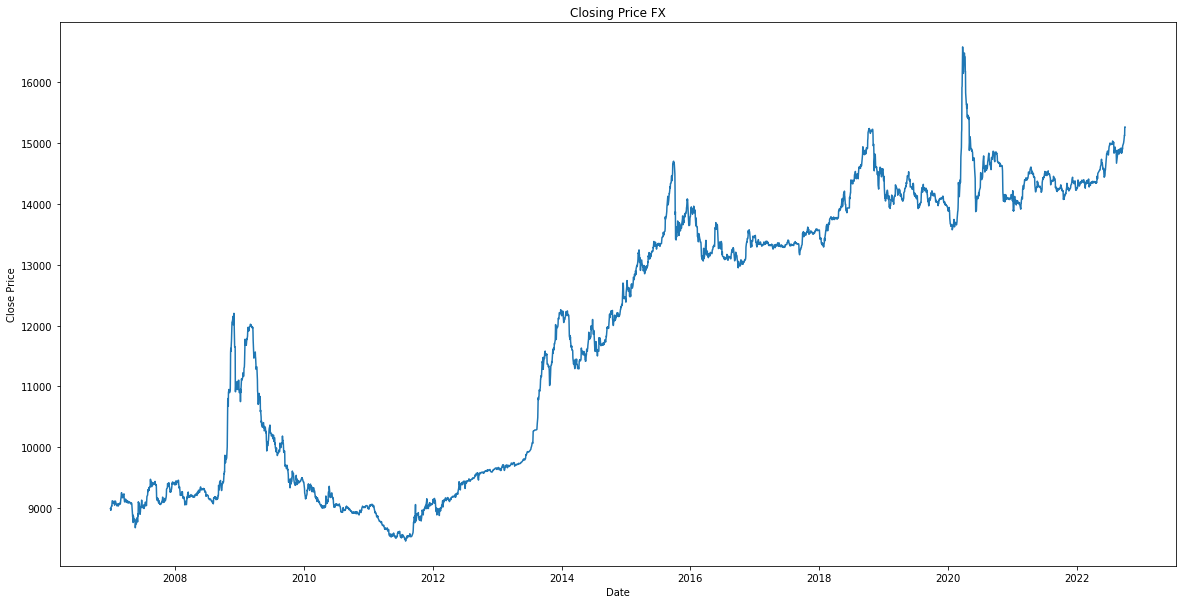

In [7]:
x_values = data['Date']
y_values = data['Close']


plt.figure(figsize =[20,10])
plt.title('Closing Price FX')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.plot(x_values, y_values)

In [8]:
data= data.drop(columns=['Date'])

In [9]:
values = data.values
values

array([[ 8993.5,  8993.5,  8993.5,  8994. ],
       [ 8983. ,  9003. ,  8938. ,  8990. ],
       [ 8980. ,  8992. ,  8960. ,  8965. ],
       ...,
       [15135. , 15172. , 15122.5, 15120. ],
       [15160. , 15276.5, 15160. , 15260. ],
       [15220. , 15280. , 15212.5, 15260. ]])

In [10]:
len(values)

4064

<Figure size 432x288 with 0 Axes>

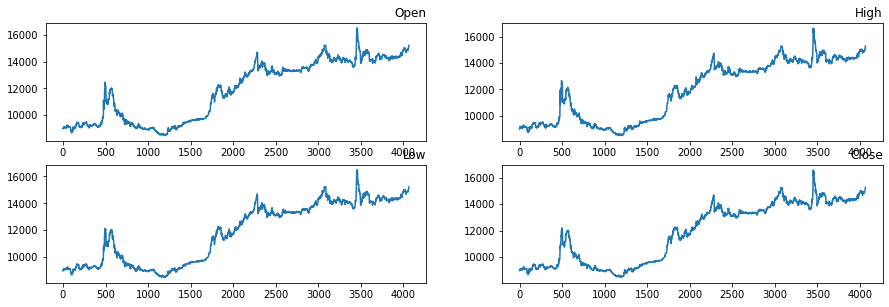

In [11]:
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
plt.figure(figsize =[15,10])
for group in groups:
	pyplot.subplot(len(groups), 2, i)
	pyplot.plot(values[:, group])
	pyplot.title(data.columns[group], y= 1, loc='right')
	i += 1
pyplot.show()

In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [13]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [14]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.066024,0.063789,0.066854,0.065804,0.064719,0.064952,0.059931,0.065311
2,0.064719,0.064952,0.059931,0.065311,0.064346,0.063606,0.062675,0.062230
3,0.064346,0.063606,0.062675,0.062230,0.064967,0.067156,0.065170,0.066543
4,0.064967,0.067156,0.065170,0.066543,0.066832,0.068258,0.067041,0.068392
5,0.066832,0.068258,0.067041,0.068392,0.068449,0.071319,0.069286,0.071473


In [15]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.066024   0.063789   0.066854   0.065804  0.064719
2   0.064719   0.064952   0.059931   0.065311  0.064346
3   0.064346   0.063606   0.062675   0.062230  0.064967
4   0.064967   0.067156   0.065170   0.066543  0.066832
5   0.066832   0.068258   0.067041   0.068392  0.068449


In [16]:
# split into train and test sets
values = reframed.values
n_train = 3287
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3287, 1, 4) (3287,) (776, 1, 4) (776,)


In [17]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [18]:
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
46/46 - 5s - loss: 0.0627 - val_loss: 0.1092
Epoch 2/200
46/46 - 0s - loss: 0.0118 - val_loss: 0.0170
Epoch 3/200
46/46 - 0s - loss: 0.0082 - val_loss: 0.0040
Epoch 4/200
46/46 - 0s - loss: 0.0061 - val_loss: 0.0019
Epoch 5/200
46/46 - 0s - loss: 0.0038 - val_loss: 7.7109e-04
Epoch 6/200
46/46 - 0s - loss: 0.0021 - val_loss: 2.4983e-04
Epoch 7/200
46/46 - 0s - loss: 0.0011 - val_loss: 6.7303e-05
Epoch 8/200
46/46 - 0s - loss: 5.2003e-04 - val_loss: 2.9874e-05
Epoch 9/200
46/46 - 0s - loss: 2.4609e-04 - val_loss: 3.8562e-05
Epoch 10/200
46/46 - 0s - loss: 1.2903e-04 - val_loss: 5.3247e-05
Epoch 11/200
46/46 - 0s - loss: 8.4612e-05 - val_loss: 6.2810e-05
Epoch 12/200
46/46 - 0s - loss: 6.9343e-05 - val_loss: 6.6817e-05
Epoch 13/200
46/46 - 0s - loss: 6.4336e-05 - val_loss: 6.7252e-05
Epoch 14/200
46/46 - 0s - loss: 6.2565e-05 - val_loss: 6.5839e-05
Epoch 15/200
46/46 - 0s - loss: 6.1730e-05 - val_loss: 6.3599e-05
Epoch 16/200
46/46 - 0s - loss: 6.1139e-05 - val_loss: 6.1042e-

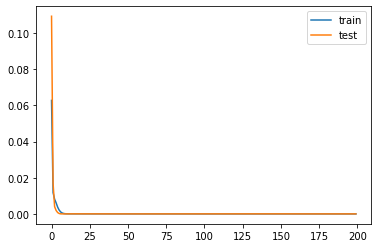

In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

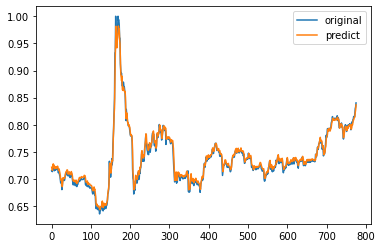

In [21]:
pyplot.plot(test_y, label="original")
pyplot.plot(yhat, label="predict")
pyplot.legend(loc="best")

In [22]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

print("Price for last 5 days: ")
print(inv_yhat[-10:])

Price for last 5 days: 
[14892.086 14933.93  14964.004 14968.403 14995.469 15006.151 15013.089
 15079.597 15116.314 15192.195]


In [23]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

print("Price for last 5 days: ")
print(inv_y[-10:])

Price for last 5 days: 
[14930.  14970.  14980.  15017.5 15007.5 15010.  15060.  15135.  15160.
 15220. ]


In [24]:
df_actual = pd.DataFrame(inv_y)
df_predict = pd.DataFrame(inv_yhat)

result = pd.concat([df_actual, df_predict], axis =1 )
result.columns = ['actual','predict']
result.head()

,actual,predict
0,14213.0,14267.083008
1,14205.0,14239.155273
2,14202.5,14220.043945
3,14257.5,14253.099609
4,14255.0,14316.769531


In [25]:
result.tail()

,actual,predict
771,15010.0,15006.151367
772,15060.0,15013.088867
773,15135.0,15079.596680
774,15160.0,15116.314453
775,15220.0,15192.195312


In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print(f'MSE: {mean_squared_error(inv_y, inv_yhat)}')
print(f'RMSE: {np.sqrt(mean_squared_error(inv_y, inv_yhat))}')
print(f'MAE: {mean_absolute_error(inv_y, inv_yhat)}')
print(f'MAPE: {mean_absolute_percentage_error(inv_y, inv_yhat)}')


def mape(inv_y, inv_yhat): 
    inv_y, inv_yhat = np.array(inv_y), np.array(inv_yhat)
    return np.mean(np.abs((inv_y - inv_yhat) / inv_yhat)) * 100
mape(inv_y, inv_yhat)
print(f'MAPE: {mape(inv_y, inv_yhat)}')

from sklearn.metrics import r2_score
print(f'R2: {r2_score(inv_y, inv_yhat)}')

#https://towardsdatascience.com/regression-analysis-lstm-network-to-predict-future-prices-b95dc0db6fcc

MSE: 2557.153076171875
RMSE: 50.568302154541016
MAE: 35.657958984375
MAPE: 0.002463549841195345
MAPE: 0.2458987757563591
R2: 0.9863447762433406


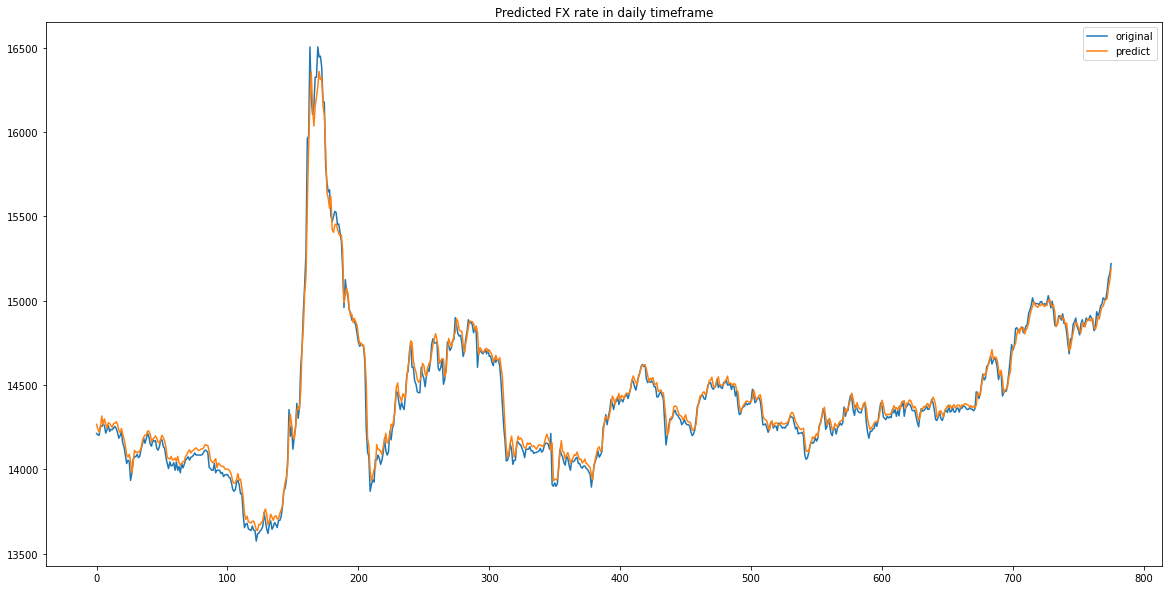

In [30]:
#visualize data

plt.figure(figsize =[20,10])
plt.title('Predicted FX rate in daily timeframe')

pyplot.plot(df_actual, label="original")
pyplot.plot(df_predict, label="predict")
pyplot.legend(loc="best")

In [29]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/